In [ ]:
import copy
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from numpy import hstack
from sklearn.preprocessing import StandardScaler
import datetime
import time
import joblib
from datetime import timedelta, date
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from numpy import array
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import os
import seaborn as sns; sns.set_theme() 
import errno
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.models import load_model
import pickle
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from scipy import interp
from imblearn.over_sampling import SMOTE
from collections import Counter
import imblearn
import collections
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from matplotlib import pyplot

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
def load_data_south_indian(url):
  df = pd.read_csv(url)
  #df.columns = ['id','date','longitude','latitude','speed']
  #df = df.drop(['date'], axis = 1)
  df['category'] = df['Speed(knots)'].apply(lambda x: 
  0 if x<=33 else 1  if x<=47 and x>=34 else 2 if x<=63 and x>=48 else 3 if x<=89 and x>=64 else 4 if x<=115 and x>=90 else 5 )
  return df

def load_data_south_pacific(url):
  df = pd.read_csv(url)
  #df.columns = ['id','date','longitude','latitude','speed']
  #df = df.drop(['date'], axis = 1)
  df['category'] = df['Speed(knots)'].apply(lambda x: 
  0 if x<=33 else 1  if x<=47 and x>=34 else 2 if x<=63 and x>=48 else 3 if x<=85 and x>=64 else 4 if x<=107 and x>=86 else 5 )
  return df

In [ ]:
ocean = 'south_indian'  #south_indian or south_pacific
print(ocean)

if ocean == 'south_indian':
    url_data = 'https://raw.githubusercontent.com/sydney-machine-learning/cyclonedatasets/main/SouthIndian-SouthPacific-Ocean/South_indian_hurricane.csv'
    function = load_data_south_indian
    hot_encoded_result_file_name = 'south_indian'
    category_result_file_name = 'roc_data_south_indian'
else:
    url_data = 'https://raw.githubusercontent.com/sydney-machine-learning/cyclonedatasets/main/SouthIndian-SouthPacific-Ocean/South_pacific_hurricane.csv'
    function = load_data_south_pacific
    hot_encoded_result_file_name = 'south_pacific'
    category_result_file_name = 'roc_data_south_pacific' 

south_indian


In [ ]:
df = function(url_data)
speed = df['Speed(knots)'].tolist()
categories = df['category'].tolist()
df.head()

,Basin,No. of Cycl,Time,V5,V6,Lat,Lon,Speed(knots),lat_tenth,lon_tenth,category
0,SI,1,1981072512,BEST,0,118S,867E,20,11.8,86.7,0
1,SI,1,1981072518,BEST,0,116S,864E,25,11.6,86.4,0
2,SI,1,1981072600,BEST,0,113S,862E,25,11.3,86.2,0
3,SI,1,1981072606,BEST,0,109S,862E,25,10.9,86.2,0
4,SI,1,1981072612,BEST,0,104S,861E,25,10.4,86.1,0


In [ ]:
def split_sequence(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, -1 ]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# split a univariate sequence into samples
def uni_split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y) 
 
def rmse(pred, actual):
    return np.sqrt(((pred-actual) ** 2).mean())

def categorical(pred, actual):
  cm = confusion_matrix(pred,actual)
  ps = precision_score(pred,actual,average='micro')
  rs = recall_score(pred,actual,average='micro')
  f1 = f1_score(pred,actual, average = 'micro')
  return cm,ps,rs,f1

def make_confusion_matrix_chart2(cf_matrix_test, name):
    #plt.figure(figsize=(20,12))
    sns.set(font_scale=2.5)
    fig, ax = plt.subplots(figsize = (20,12))
    sns.heatmap(cf_matrix_test, annot=True, yticklabels=['0','1','2','3','4','5'], 
                                xticklabels=['0','1','2','3','4','5'], fmt='g')
    plt.ylabel("Actual", size=30)
    plt.xlabel("Pred", size=30)
    ax.tick_params(axis='both', which='major', labelsize=25)
    plt.savefig(name + '.png', dpi=300, transparent=False, bbox_inches='tight')
    return None 

In [ ]:
univariate = True # if false, its multivariate case
n_steps_in = 4
n_seq = 2
n_steps_out = 1
n_features_in = 1 #speed
n_features_out = 6 # one hot encoding of category
Hidden = 10
Epochs = 100
Num_Exp = 3

In [ ]:
id = df['No. of Cycl'][0]
count = 0
X = []
Y = []
start_index=0
end_index=0
for i in range(1, df.shape[0]):
  if df['No. of Cycl'][i] == id :
    end_index+=1
  else:
    x,y = uni_split_sequence(speed[start_index:end_index+1], n_steps_in)
    X.append(x)
    Y.append(y)
    id = df['No. of Cycl'][i]
    start_index=i
    end_index=i
  if i == df.shape[0]-1:   
    x,y = uni_split_sequence(speed[start_index:end_index+1], n_steps_in)
    X.append(x)
    Y.append(y)    

In [ ]:
print(len(X), len(Y))
X = [item for sublist in X for item in sublist]
Y = [item for sublist in Y for item in sublist]
print(len(X), len(Y))
print(X[0], Y[0], X[1], Y[1])
print(speed[:10])

670 670
21454 21454
[20 25 25 25] 25 [25 25 25 25] 30
[20, 25, 25, 25, 25, 30, 30, 30, 25, 25]


In [ ]:
tmp = pd.DataFrame({'col': Y})
if ocean == 'south_pacific':
  category = tmp['col'].apply(lambda x: 
  0 if x<=33 else 1  if x<=47 and x>=34 else 2 if x<=63 and x>=48 else 3 if x<=85 and x>=64 else 4 if x<=107 and x>=86 else 5 )
else:
  category = tmp['col'].apply(lambda x: 
  0 if x<=33 else 1  if x<=47 and x>=34 else 2 if x<=63 and x>=48 else 3 if x<=89 and x>=64 else 4 if x<=115 and x>=90 else 5 )

Y=category

In [ ]:
train_limit = int(len(X)*70/100)
train_limit

15017

In [ ]:
test_X_original = X[train_limit+1:]
#X_original = X[:train_limit]
#X_original = np.asarray(X_original).astype(float)
test_Y_original = Y[train_limit+1:]
#Y_original = Y[:train_limit]
len(X), len(Y), len(test_X_original), len(test_Y_original)

(21454, 21454, 6436, 6436)

In [ ]:
X = MinMaxScaler().fit_transform(np.asarray(X))

In [ ]:
speed_x = X
test_X = X[train_limit+1:]
test_X = np.asarray(test_X).astype(float)
test_Y = Y[train_limit+1:]
X = X[:train_limit]
X = np.asarray(X).astype(float)
Y = Y[:train_limit]
print(len(test_X), len(test_Y))
len(X), len(Y)

6436 6436


(15017, 15017)

In [ ]:
counter_train = collections.OrderedDict(sorted(Counter(Y).items()))
counter_test = collections.OrderedDict(sorted(Counter(test_Y).items()))
print("train data: ", counter_train)
print("test data: ", counter_test)

train data:  OrderedDict([(0, 4727), (1, 3819), (2, 2060), (3, 2254), (4, 1743), (5, 414)])
test data:  OrderedDict([(0, 1303), (1, 1155), (2, 1082), (3, 1258), (4, 1350), (5, 288)])


<Figure size 432x288 with 0 Axes>

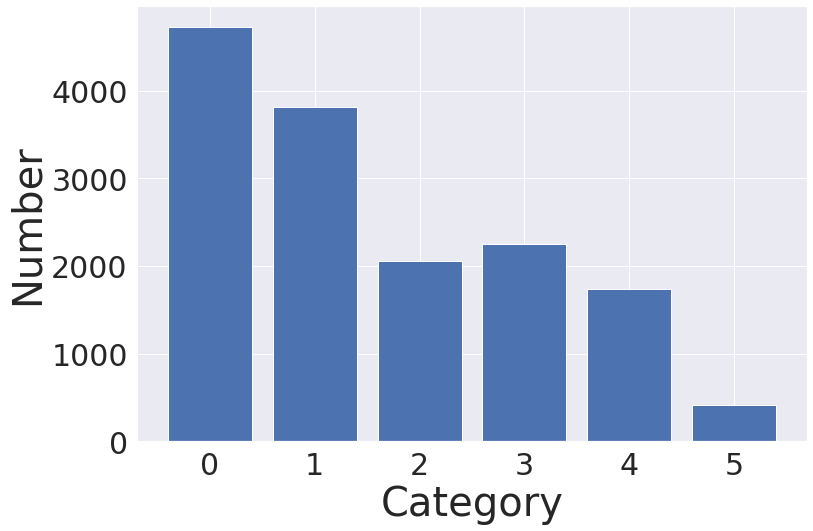

In [ ]:
plt.figure()
#fig = plt.subplots(figsize =(20, 12))
fig, ax = plt.subplots(figsize = (12,8))
plt.bar(range(len(counter_train)), list(counter_train.values()), align='center')
plt.xticks(range(len(counter_train)), list(counter_train.keys()))
plt.xlabel('Category', size=40)
plt.ylabel('Number', size=40)
#plt.title('ROC' + ' (' + str(no_of_output_steps) + ' steps ahead, ' + model.capitalize() + ', Time step: ' + str(time_step) + ') - ' + train_or_test.capitalize() + ' (' + ocean + '_ocean)')
ax.tick_params(axis='both', which='major', labelsize=30)
plt.savefig(ocean + '_class_dist.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

In [ ]:
def vanilla(n_steps_in,n_steps_out,n_features_in, n_features_out):
  model = Sequential()
  model.add(LSTM(Hidden, activation='relu', input_shape=(n_steps_in, n_features_in)))
  model.add(Dense(n_features_out, activation = "softmax"))
  model.compile(optimizer='adam', loss='categorical_crossentropy')
  return model
 
  #model = Sequential()
  #model.add(LSTM(Hidden, activation='relu', input_shape=(n_steps_in, n_features_in)))
  #model.add(RepeatVector(n_steps_out))
  #model.add(LSTM(Hidden, activation='relu', return_sequences=True))
  #model.add(TimeDistributed(Dense(n_features_out, activation = "softmax")))
  #model.compile(optimizer='adam', loss='categorical_crossentropy')
  #return model

def bidirectional(n_steps_in,n_steps_out,n_features_in, n_features_out):
  model = Sequential()
  model.add(Bidirectional(LSTM(Hidden, activation='relu', input_shape=(n_steps_in, n_features_in))))
  model.add(Dense(n_features_out, activation = "softmax"))
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

def cnn_lstm(n_steps_in,n_steps_out,n_features_in, n_features_out, n_seq):
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, int(n_steps_in/n_seq), n_features_in)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(Hidden, activation='relu'))
  model.add(Dense(n_features_out, activation = "softmax"))
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

def conv_lstm(n_steps_in,n_steps_out,n_features_in, n_features_out, n_seq):
  model = Sequential()
  model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, int(n_steps_in/n_seq), n_features_in)))
  model.add(Flatten())
  model.add(Dense(n_features_out, activation = "softmax"))
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

In [ ]:
idx = np.random.permutation(len(X))
print(len(idx))
x_shuffled = []
y_shuffled = []
for i in idx:
  x_shuffled.append(X[i])
  y_shuffled.append(Y[i])

15017


In [ ]:
Y_hot_encoded_train =  np.asarray(to_categorical(y_shuffled))
#Y_hot_encoded_train = Y_hot_encoded_train.reshape(len(y_shuffled), n_steps_out, n_features_out)

Y_hot_encoded_test =  np.asarray(to_categorical(test_Y))
#Y_hot_encoded_test = Y_hot_encoded_test.reshape(len(test_Y), n_steps_out, n_features_out)

print(Y_hot_encoded_train.shape, Y_hot_encoded_test.shape)

(15017, 6) (6436, 6)


In [ ]:
x_shuffled[0], test_X[0]

(array([0.10344828, 0.07142857, 0.07142857, 0.10344828]),
 array([0.10344828, 0.07142857, 0.14285714, 0.17241379]))

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

In [ ]:
fake_y_value = 2 #class id of fake data

In [ ]:
x_shuffled = X
y_shuffled = Y
print(len(x_shuffled), len(X), len(y_shuffled)) 
t2 = np.asarray(x_shuffled).shape
X_oversampled = torch.from_numpy(np.asarray(x_shuffled))

15017 15017 15017


In [ ]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )
class Generator(nn.Module):

    def __init__(self, z_dim=t2[1], im_dim=t2[1], hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)
    
    
    def get_gen(self):

        return self.gen
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)        
    )
class Discriminator(nn.Module):
    def __init__(self, im_dim=t2[1], hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):

        return self.disc(image)
    
    def get_disc(self):

        return self.dis
def get_noise(n_samples, z_dim, device='cuda'):

    return torch.randn(n_samples,z_dim,device=device) 

In [ ]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 1000
z_dim = t2[1]
batch_size = 128
lr = 0.00001
display_step = 1
device = 'cuda'
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):

    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):

    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

In [ ]:
li=[]
for i in range(len(y_shuffled)):
    if int(y_shuffled[i])==fake_y_value:
        li.append(x_shuffled[i])
        
print(len(y_shuffled), len(li))

X_real=np.array(li)
t3=X_real.shape
li2=[1]*(t3[0])
y_real=np.array(li2)
y_real.shape

from torch.utils.data import TensorDataset, DataLoader
tensor_x = torch.Tensor(X_real) 
tensor_y = torch.Tensor(y_real)
my_dataset = TensorDataset(tensor_x,tensor_y)
dataloader = DataLoader(
    my_dataset,
    batch_size=batch_size,
    shuffle=True)

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True 
gen_loss = False
error = False

15017 2060


In [ ]:
samples_to_generate = int((X_oversampled.shape[0]-X_real.shape[0])/6)
print(samples_to_generate)

#epochs = [100,500,1000,2000,3000,4000,5000]
epochs = [1000]

smote_gan_data = dict()

2159


In [ ]:
def augment_data():
  fake_noise = get_noise(samples_to_generate, z_dim, device=device)
  res=gen(fake_noise)
  fres=res.cpu().detach().numpy()
  X_old=X
  finX=np.concatenate((X_old, fres), axis=0)
  y_fake = np.full(shape=samples_to_generate,fill_value=fake_y_value)
  Y_old=np.asarray(Y)
  finY = np.append(Y_old, y_fake, axis=0)
  idx = np.random.permutation(finX.shape[0])
  x_shuffled = []
  y_shuffled = []
  for i in idx:
    x_shuffled.append(finX[i])
    y_shuffled.append(finY[i])
  x_shuffled = np.asarray(x_shuffled)
  x_shuffled = x_shuffled.reshape((x_shuffled.shape[0], x_shuffled.shape[1], n_features_in))
  y_shuffled = np.asarray(to_categorical(y_shuffled))
  return x_shuffled, y_shuffled

In [ ]:
x_test = np.asarray(test_X)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features_in))

In [ ]:
master_slave_results = dict()
master_slave_test_acc = dict()

In [ ]:
for no_epoch in epochs:
  print("no of epochs: ", no_epoch)
  model = vanilla(n_steps_in,n_steps_out,n_features_in,n_features_out)
  for epoch in range(no_epoch):
    for real, _ in tqdm(dataloader, disable=True):
        cur_batch_size = len(real) 
        real = real.view(cur_batch_size, -1).to(device)  
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")
        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step
        #calling classifier after every 10 epochs of GAN
        if(epoch%10==0):
          print(f"Epoch {epoch}: Step {cur_step}: Generator loss: {mean_generator_loss},discriminator loss: {mean_discriminator_loss}")
        if cur_step % display_step == 0 and cur_step > 0:
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

    if epoch%10==0 and epoch>0:
      print(f"Epoch {epoch}")
      if(epoch!=10 and epoch>0):
        model.load_weights('my_model_weights.h5')
      x_train, y_train = augment_data()
      model.fit(x_train, y_train, epochs=10, batch_size=10, verbose=0, shuffle=False)
      y_predicttest = model.predict(x_test)
      pred_test = [y_predicttest[i].argmax() for i in range(y_predicttest.shape[0])]
      report_test = classification_report(test_Y, pred_test, labels=[0,1,2,3,4,5], output_dict=True)
      print("accuracy: ", report_test[str(fake_y_value)]['f1-score'])
      master_slave_results[epoch]=report_test
      master_slave_test_acc[epoch]=report_test[str(fake_y_value)]['f1-score']
      model.save_weights('my_model_weights.h5')

no of epochs:  1000
Epoch 0: Step 0: Generator loss: 0.681206226348877,discriminator loss: 0.6955541968345642
Epoch 0: Step 1: Generator loss: 1.363266110420227,discriminator loss: 1.390764594078064
Epoch 0: Step 2: Generator loss: 0.6829104423522949,discriminator loss: 0.6949605941772461
Epoch 0: Step 3: Generator loss: 0.6836707592010498,discriminator loss: 0.6946296691894531
Epoch 0: Step 4: Generator loss: 0.6845188140869141,discriminator loss: 0.6944134831428528
Epoch 0: Step 5: Generator loss: 0.6853058338165283,discriminator loss: 0.6941161751747131
Epoch 0: Step 6: Generator loss: 0.686143159866333,discriminator loss: 0.6939059495925903
Epoch 0: Step 7: Generator loss: 0.6869192719459534,discriminator loss: 0.693584680557251
Epoch 0: Step 8: Generator loss: 0.687742292881012,discriminator loss: 0.6933552622795105
Epoch 0: Step 9: Generator loss: 0.688555121421814,discriminator loss: 0.6931544542312622
Epoch 0: Step 10: Generator loss: 0.6892883777618408,discriminator loss: 0.69

In [ ]:
for k in master_slave_test_acc:
  if(k%100==0):
    print("epoch: ",k,master_slave_test_acc[k])